In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
from statistics import mean

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 10
batch_size = 32
lr = 0.01
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
def plot_graph(training_losses,val_losses,epochs):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training loss")
    plt.plot(range(epochs),val_losses,label="Validation loss")
    plt.legend()
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(3136, 1200)
        self.fc2 = nn.Linear(1200,50)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        #x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(-1, 320)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [6]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,labels)
            epoch_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss



Average training loss: 0.6696826524237792
Average loss: 0.3912, Accuracy: 10292/12000 (86%)
Average training loss: 0.38528973823289075
Average loss: 0.3229, Accuracy: 10547/12000 (88%)
Average training loss: 0.32111158910393717
Average loss: 0.3125, Accuracy: 10605/12000 (88%)
Average training loss: 0.28771842455367247
Average loss: 0.2634, Accuracy: 10813/12000 (90%)
Average training loss: 0.26315416077524423
Average loss: 0.2578, Accuracy: 10890/12000 (91%)
Average training loss: 0.2445109221426149
Average loss: 0.2522, Accuracy: 10871/12000 (91%)
Average training loss: 0.22498503809049725
Average loss: 0.2354, Accuracy: 10932/12000 (91%)
Average training loss: 0.2123302091366301
Average loss: 0.2376, Accuracy: 10942/12000 (91%)
Average training loss: 0.19926833740994335
Average loss: 0.2233, Accuracy: 10993/12000 (92%)
Average training loss: 0.18696518838219345
Average loss: 0.2269, Accuracy: 11003/12000 (92%)
Final performance
Average loss: 0.2376, Accuracy: 9159/10000 (92%)


0.23762545216911898

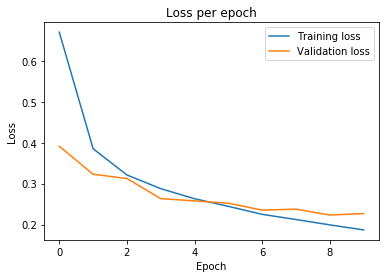

In [7]:
model = Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader,criterion)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(p=0.25)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,images)
            epoch_loss += loss.item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}'.format(epoch_loss))
    return epoch_loss



Average training loss: 0.06826146183907986
Average loss: 0.0298
Average training loss: 0.03249887989461422
Average loss: 0.0205
Average training loss: 0.026255593032886583
Average loss: 0.0180
Average training loss: 0.02337679341311256
Average loss: 0.0166
Average training loss: 0.021335359249264003
Average loss: 0.0156
Average training loss: 0.019812968663871288
Average loss: 0.0147
Average training loss: 0.018570163076122602
Average loss: 0.0142
Average training loss: 0.017583114594221114
Average loss: 0.0136
Average training loss: 0.016775523977975052
Average loss: 0.0136
Average training loss: 0.01610042322613299
Average loss: 0.0132
Final performance
Average loss: 0.0133


0.013284708081652372

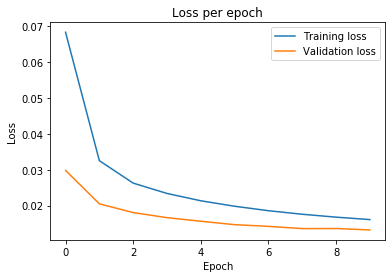

In [10]:
model = AutoEncoder().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader,criterion)


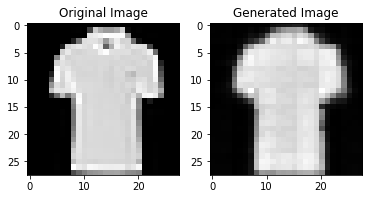

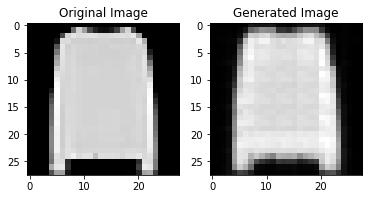

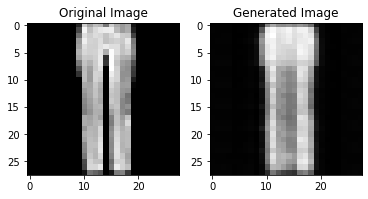

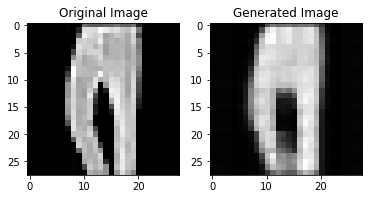

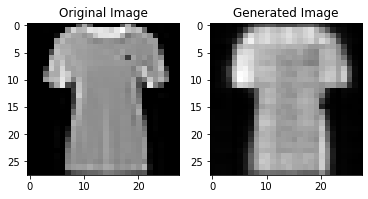

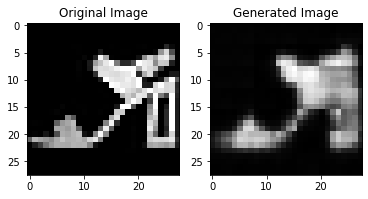

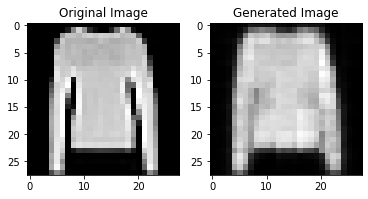

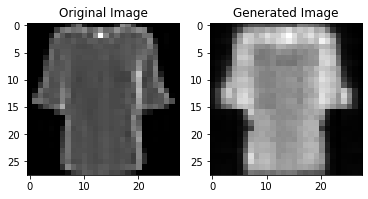

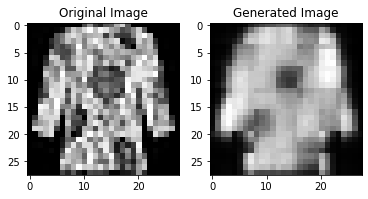

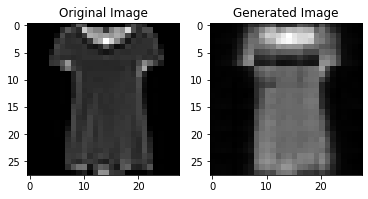

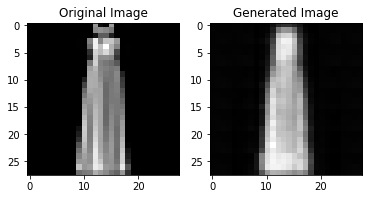

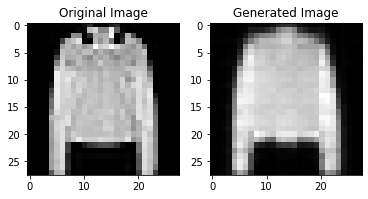

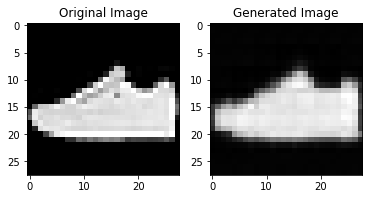

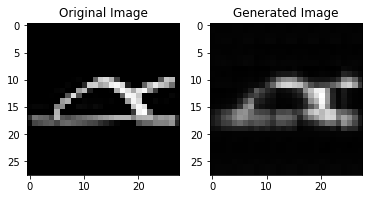

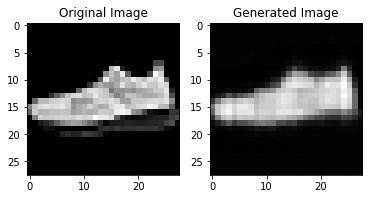

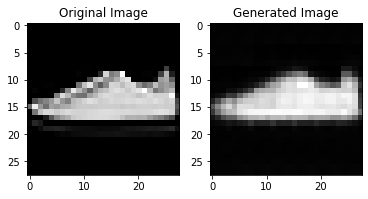

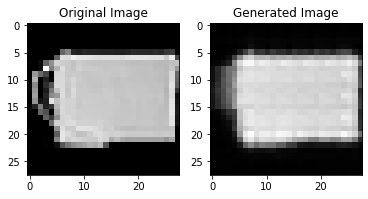

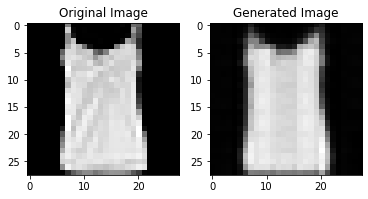

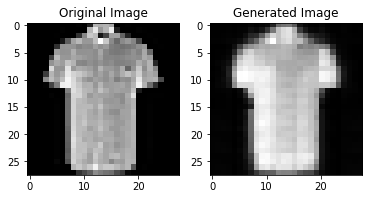

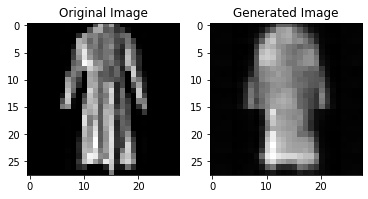

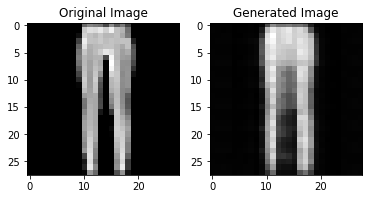

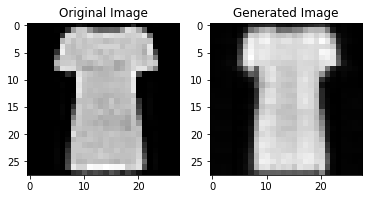

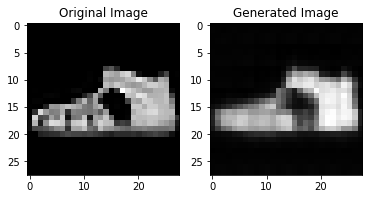

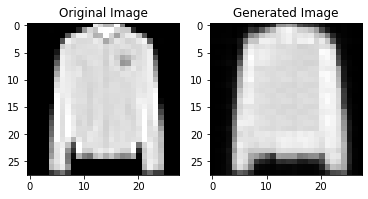

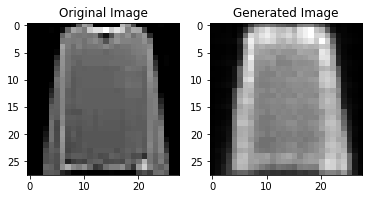

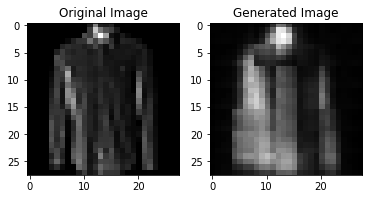

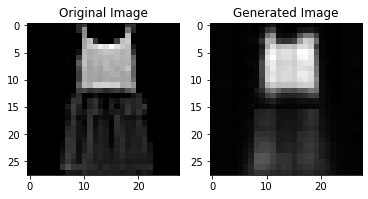

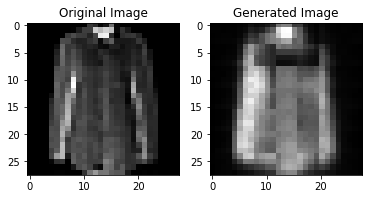

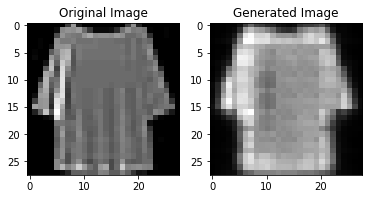

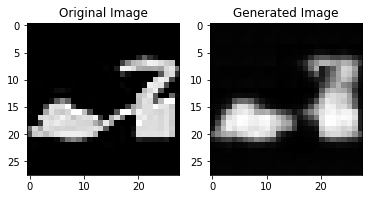

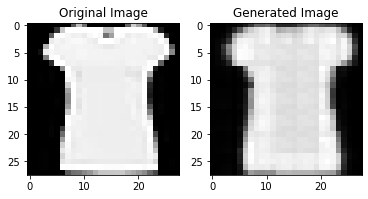

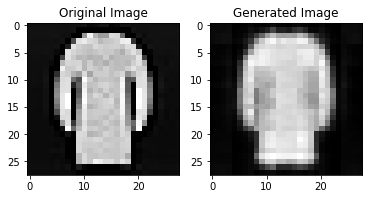

In [11]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

In [12]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,1200),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(1200,500),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(500,10),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted

In [13]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = criterion1(decoded,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss

Average training loss: 0.7332258212864399
Average loss: 0.4282, Accuracy: 10254/12000 (85%)
Average training loss: 0.4275764238337676
Average loss: 0.3879, Accuracy: 10379/12000 (86%)
Average training loss: 0.35992589564124744
Average loss: 0.3273, Accuracy: 10609/12000 (88%)
Average training loss: 0.3243989134033521
Average loss: 0.2956, Accuracy: 10755/12000 (90%)
Average training loss: 0.2952014144087831
Average loss: 0.2986, Accuracy: 10686/12000 (89%)
Average training loss: 0.2757989405641953
Average loss: 0.2643, Accuracy: 10874/12000 (91%)
Average training loss: 0.25559560249745844
Average loss: 0.2572, Accuracy: 10902/12000 (91%)
Average training loss: 0.2414405117953817
Average loss: 0.2654, Accuracy: 10860/12000 (90%)
Average training loss: 0.22720622967928647
Average loss: 0.2490, Accuracy: 10983/12000 (92%)
Average training loss: 0.2172347302759687
Average loss: 0.2562, Accuracy: 10976/12000 (91%)
Final performance
Average loss: 0.2718, Accuracy: 9117/10000 (91%)


0.2717709549057027

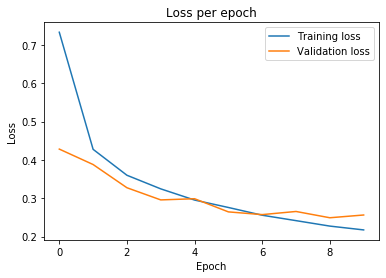

In [14]:
model = Mixed().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader)
    val_loss = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader)

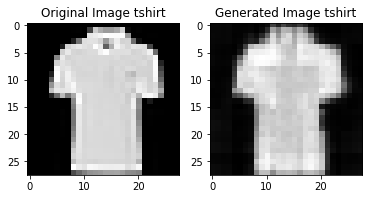

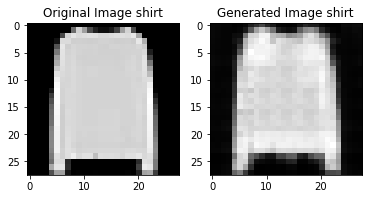

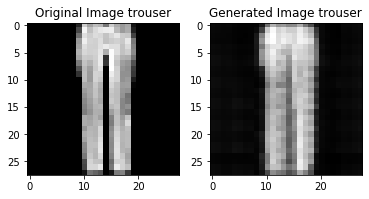

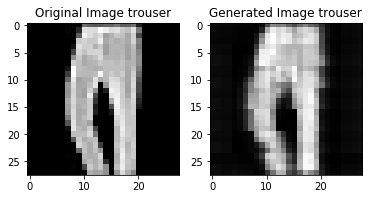

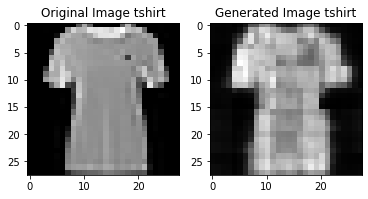

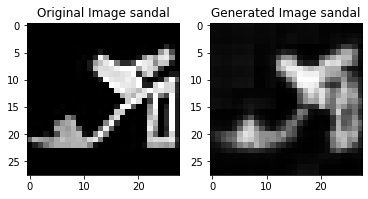

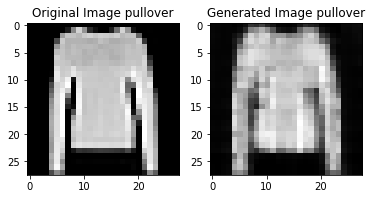

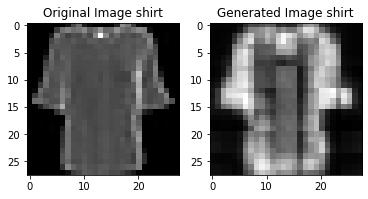

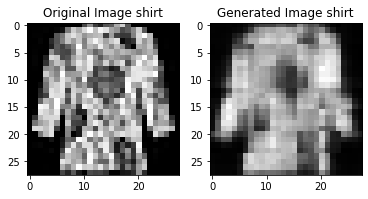

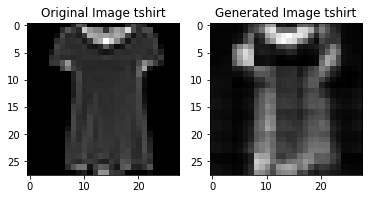

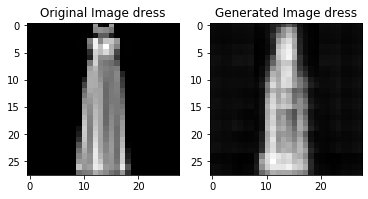

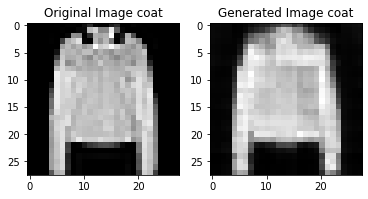

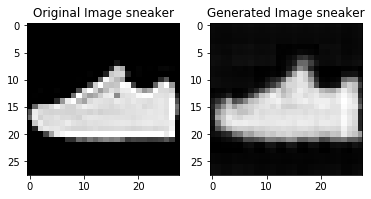

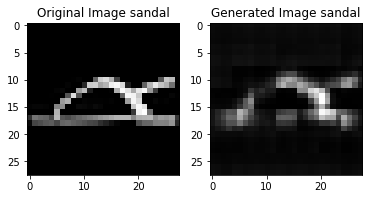

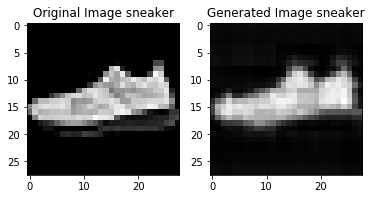

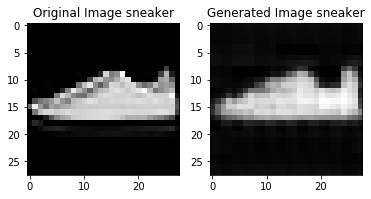

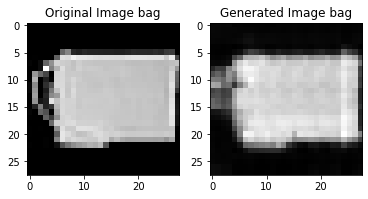

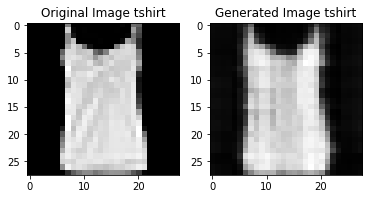

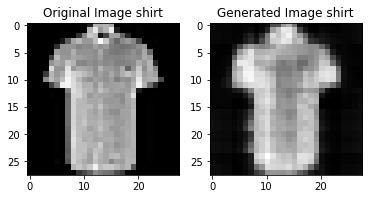

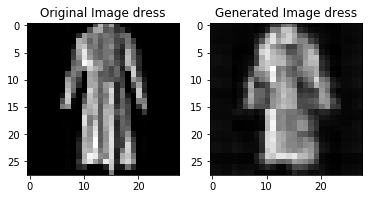

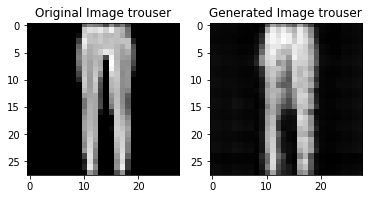

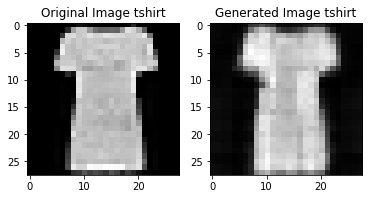

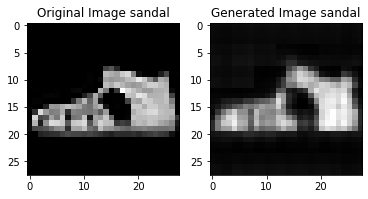

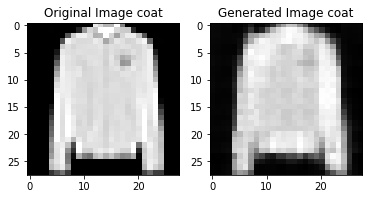

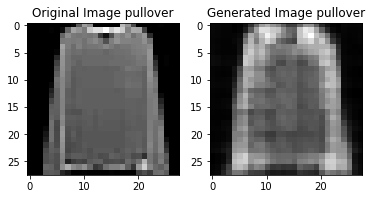

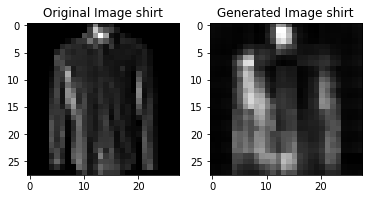

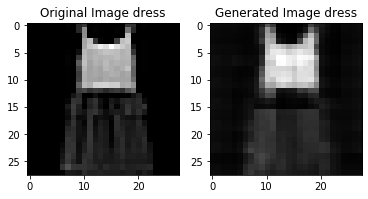

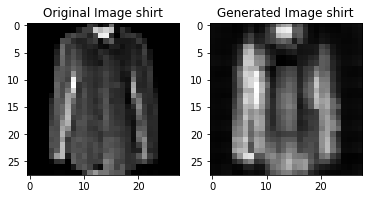

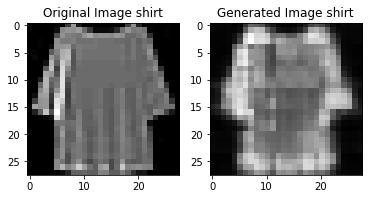

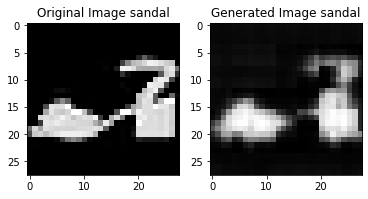

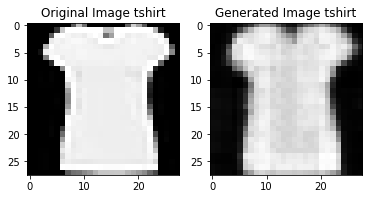

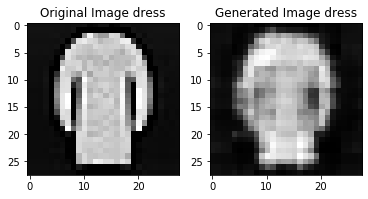

In [15]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()